# Podcast Recommendation System with Hybrid Neural Collaborative Filtering


We will train our model using three different data splits:

1. **Temporal 80–20% split among active users** (users with 3 or more reviews)  
2. **Random 80–20% split among active users**  
3. **Active-user stratified 80–20% split**, where each active user has at least 2 reviews in the training set and at least 1 review in the test set  

**Reminder:**  
In the `dataPreprocessing.ipynb` notebook, we started with a dataset of over 5 million reviews and filtered it down to 2.9 million reviews from active users only.  

We currently have:  
- Temporal 80–20% train and test splits saved in **Parquet** format (including BERT-based review embeddings as features)  
- Pickled encoders for **`author_id`** and **`podcast_id`**


---
## 1. Setup and Data Loading

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import sys
import gc
import time
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Import config and models
from config import Config
sys.path.insert(0, str(Config.DATA_DIR.parent))
from models import HybridNCF, create_model

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load Data
DATA_DIR = Config.DATA_DIR.parent

with open(DATA_DIR / 'encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
    user_encoder = encoders['user_encoder']
    podcast_encoder = encoders['podcast_encoder']

columns_to_load = ['auth_id_encoded', 'podcast_id_encoded', 'rating', 'bert_embedding_all-MiniLM-L6-v2']

train_df = pd.read_parquet(DATA_DIR / 'train.parquet', columns=columns_to_load)
test_df = pd.read_parquet(DATA_DIR / 'test.parquet', columns=columns_to_load)

print(f"  Train samples: {len(train_df):,}")
print(f"  Test samples: {len(test_df):,}")
print(f"  Unique users: {train_df['auth_id_encoded'].nunique():,}")
print(f"  Unique podcasts: {train_df['podcast_id_encoded'].nunique():,}")
print(f"  BERT embedding dim: {len(train_df['bert_embedding_all-MiniLM-L6-v2'].iloc[0])}")

  Train samples: 1,833,084
  Test samples: 458,271
  Unique users: 376,288
  Unique podcasts: 162,118
  BERT embedding dim: 384


## 2. Model Architecture

### Hybrid Neural Collaborative Filtering (NCF)

The model combines **collaborative filtering**, **content-based filtering**, and a **deep fusion network**:

- **Collaborative filtering:** user and item embeddings with interaction terms and bias embeddings  
- **Content-based filtering:** 384-dimensional BERT embeddings from *all-MiniLM-L6-v2* projected to 64 dimensions  
- **Deep fusion network:** two MLP layers (128 → 64 units) with ReLU activation, batch normalization, dropout (0.2), and L2 regularization (1e-5)  

**Training configuration:**
- Optimizer: Adam (learning rate = 0.0002, gradient clipping)
- Loss: Mean Squared Error (MSE)
- Early stopping: patience = 5
- Learning rate reduction on plateau: factor = 0.5, patience = 4  

This hybrid approach enables the model to generate recommendations based on both user behavior patterns and podcast content characteristics, while capturing complex non-linear relationships between these signals.


## 2.1 Temporal Split

In [3]:
# Aggregate BERT Embeddings by Podcast
n_podcasts = train_df['podcast_id_encoded'].max() + 1
embedding_dim = len(train_df['bert_embedding_all-MiniLM-L6-v2'].iloc[0])

pretrained_podcast_embeddings = np.zeros((n_podcasts, embedding_dim), dtype=np.float32)
embedding_counts = np.zeros(n_podcasts, dtype=np.int32)

# Process in chunks to manage memory
chunk_size = 500000
n_chunks = (len(train_df) + chunk_size - 1) // chunk_size

print(f"\nProcessing {len(train_df):,} rows in {n_chunks} chunks...")
for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(train_df))

    chunk_embeddings = np.stack(train_df['bert_embedding_all-MiniLM-L6-v2'].iloc[start_idx:end_idx].values)
    chunk_podcast_ids = train_df['podcast_id_encoded'].iloc[start_idx:end_idx].values

    # Vectorized accumulation (faster than Python loop)
    np.add.at(pretrained_podcast_embeddings, chunk_podcast_ids, chunk_embeddings)
    np.add.at(embedding_counts, chunk_podcast_ids, 1)

    del chunk_embeddings, chunk_podcast_ids

    if (i + 1) % 2 == 0 or i == n_chunks - 1:
        print(f"  Processed {min(end_idx, len(train_df)):,}/{len(train_df):,} rows...")
        gc.collect()

# Average embeddings
mask = embedding_counts > 0
pretrained_podcast_embeddings[mask] /= embedding_counts[mask, np.newaxis]

del embedding_counts, mask
gc.collect()

print(f"  Shape: {pretrained_podcast_embeddings.shape}")
print(f"  Memory: {pretrained_podcast_embeddings.nbytes / 1024**2:.1f} MB")
print(f"  Podcasts with embeddings: {(pretrained_podcast_embeddings.sum(axis=1) != 0).sum():,}")


Processing 1,833,084 rows in 4 chunks...
  Processed 1,000,000/1,833,084 rows...
  Processed 1,833,084/1,833,084 rows...
  Shape: (182005, 384)
  Memory: 266.6 MB
  Podcasts with embeddings: 162,118


In [4]:
# Prepare Training Data
n_users = train_df['auth_id_encoded'].max() + 1
n_podcasts = train_df['podcast_id_encoded'].max() + 1

# Use int32 instead of int64 to save memory
X_train = {
    'user': train_df['auth_id_encoded'].values.astype(np.int32),
    'item': train_df['podcast_id_encoded'].values.astype(np.int32)
}
y_train = train_df['rating'].values.astype(np.float32)

X_test = {
    'user': test_df['auth_id_encoded'].values.astype(np.int32),
    'item': test_df['podcast_id_encoded'].values.astype(np.int32)
}
y_test = test_df['rating'].values.astype(np.float32)



In [5]:
# Define Model Configuration
config = {
    'name': 'Hybrid NCF',
    'embedding_dim': 64,
    'mlp_layers': [128, 64],
    'dropout_rate': 0.2,
    'freeze_pretrained': False,
    'l2_reg': 1e-5,
    'learning_rate': 0.0002
}

In [6]:
# Create model
model = create_model(n_users, n_podcasts, pretrained_podcast_embeddings, config)

optimizer = Adam(
    learning_rate=config['learning_rate'],
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [7]:
# Setup callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.0001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

start_time = time.time()

history = model.fit(
    X_train, y_train,
    batch_size=2048,
    epochs=30,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"Training complete! Time: {training_time:.1f}s ({training_time/60:.1f} min)")
model.summary()

Epoch 1/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 18.3397 - mae: 4.0349 - val_loss: 4.0053 - val_mae: 1.9190 - learning_rate: 2.0000e-04
Epoch 2/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 2.7998 - mae: 1.3272 - val_loss: 0.8380 - val_mae: 0.5883 - learning_rate: 2.0000e-04
Epoch 3/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1.2955 - mae: 0.8210 - val_loss: 0.8330 - val_mae: 0.5703 - learning_rate: 2.0000e-04
Epoch 4/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.9607 - mae: 0.6856 - val_loss: 0.8317 - val_mae: 0.5352 - learning_rate: 2.0000e-04
Epoch 5/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7635 - mae: 0.5993 - val_loss: 0.8472 - val_mae: 0.5237 - learning_rate: 2.0000e-04
Epoch 6/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.6274 - mae: 0.5350 - val_loss: 0.8630 - val_mae: 0.4997 - learning_rate: 2.0000e-04
Epoch 7/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.5270 - mae: 0.4843 - val_loss: 0.8645 - val_mae

Model: "hybrid_ncf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1)              │       398,209 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 1)              │       182,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_cf_embedding (Embedding)   │ (None, 64)             │    25,485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_cf_embedding (Embedding)   │ (None, 64)             │    11,648,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_content_embedding          │ (None, 384)            │    69,889,920 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ content_projection (Dense)      │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_dense_0 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_bn_0                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_dropout_0 (Dropout)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_dense_1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_bn_1                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fusion_dropout_1 (Dropout)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,010,599 (1.20 GB)

 Trainable params: 107,670,071 (410.73 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 215,340,144 (821.46 MB)

Model Evaluation:

In [8]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, batch_size=2048, verbose=0).flatten()
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"\nTest Set Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  MSE:  {test_loss:.4f}")
print(f"  R²:   {r2:.4f}")



Test Set Performance:
  RMSE: 1.2390
  MAE:  0.8443
  MSE:  1.5572
  R²:   0.1383


## 2.2 Random Split

In [9]:
# Combine temporal test and train files into one dataset
full_data = pd.concat([train_df, test_df], ignore_index=True)

from sklearn.model_selection import train_test_split

# Random split
train_df_random, test_df_random = train_test_split(
    full_data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Aggregate BERT embeddings (from random train set)

n_podcasts_random = full_data['podcast_id_encoded'].max() + 1
embedding_dim_random = len(full_data['bert_embedding_all-MiniLM-L6-v2'].iloc[0])

pretrained_podcast_embeddings_random = np.zeros((n_podcasts_random, embedding_dim_random), dtype=np.float32)
embedding_counts_random = np.zeros(n_podcasts_random, dtype=np.int32)

# Aggregate from random train set
chunk_size = 500000
n_chunks = (len(train_df_random) + chunk_size - 1) // chunk_size

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(train_df_random))

    chunk_embeddings = np.stack(train_df_random['bert_embedding_all-MiniLM-L6-v2'].iloc[start_idx:end_idx].values)
    chunk_podcast_ids = train_df_random['podcast_id_encoded'].iloc[start_idx:end_idx].values

    np.add.at(pretrained_podcast_embeddings_random, chunk_podcast_ids, chunk_embeddings)
    np.add.at(embedding_counts_random, chunk_podcast_ids, 1)

    del chunk_embeddings, chunk_podcast_ids

    if (i + 1) % 2 == 0 or i == n_chunks - 1:
        print(f"  Processed {min(end_idx, len(train_df_random)):,}/{len(train_df_random):,} rows...")
        gc.collect()

# Average
mask_random = embedding_counts_random > 0
pretrained_podcast_embeddings_random[mask_random] /= embedding_counts_random[mask_random, np.newaxis]

del embedding_counts_random, mask_random
gc.collect()

# Prepare training arrays

n_users_random = full_data['auth_id_encoded'].max() + 1
n_podcasts_random = full_data['podcast_id_encoded'].max() + 1

X_train_random = {
    'user': train_df_random['auth_id_encoded'].values.astype(np.int32),
    'item': train_df_random['podcast_id_encoded'].values.astype(np.int32)
}
y_train_random = train_df_random['rating'].values.astype(np.float32)

X_test_random = {
    'user': test_df_random['auth_id_encoded'].values.astype(np.int32),
    'item': test_df_random['podcast_id_encoded'].values.astype(np.int32)
}
y_test_random = test_df_random['rating'].values.astype(np.float32)

# Free memory
del train_df_random, test_df_random

tf.keras.backend.clear_session()
gc.collect()

model_random = create_model(
    n_users_random,
    n_podcasts_random,
    pretrained_podcast_embeddings_random,
    config
)

optimizer_random = Adam(
    learning_rate=config['learning_rate'],
    clipnorm=1.0
)

model_random.compile(optimizer=optimizer_random, loss='mse', metrics=['mae'])

# Setup callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.0001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

start_time = time.time()

history_random = model_random.fit(
    X_train_random, y_train_random,
    batch_size=2048,
    epochs=30,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

training_time_random = time.time() - start_time


predictions_random = model_random.predict(X_test_random, batch_size=2048, verbose=0).flatten()
rmse_random = np.sqrt(mean_squared_error(y_test_random, predictions_random))
mae_random = mean_absolute_error(y_test_random, predictions_random)
r2_random = r2_score(y_test_random, predictions_random)

print(f"\nRandom Split Performance:")
print(f"  RMSE: {rmse_random:.4f}")
print(f"  MAE: {mae_random:.4f}")
print(f"  R²: {r2_random:.4f}")


  Processed 1,000,000/1,833,084 rows...
  Processed 1,833,084/1,833,084 rows...
Epoch 1/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 18.2132 - mae: 3.9938 - val_loss: 3.2100 - val_mae: 1.6949 - learning_rate: 2.0000e-04
Epoch 2/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 2.7400 - mae: 1.3050 - val_loss: 0.9892 - val_mae: 0.6170 - learning_rate: 2.0000e-04
Epoch 3/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1.3352 - mae: 0.8365 - val_loss: 0.9715 - val_mae: 0.5759 - learning_rate: 2.0000e-04
Epoch 4/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.9802 - mae: 0.6949 - val_loss: 0.9804 - val_mae: 0.5700 - learning_rate: 2.0000e-04
Epoch 5/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7819 - mae: 0.6077 - val_loss: 0.9969 - val_mae: 0.5467 - learning_rate: 2.0000e-04
Epoch 6/30
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.6403 - mae: 0.5414 - val_loss: 1.0184 - val_mae: 0.5383 - learning_rate: 2.0000e-04
Epoch 7/30
760/761 ━━━━━━━━━━━━

## 2.3 User-stratified


In [10]:
# Create user-stratified split
user_groups = full_data.groupby('auth_id_encoded')

train_indices = []
test_indices = []

users_kept = 0
users_dropped = 0
total_train_samples = 0
total_test_samples = 0

for user_id, group_df in user_groups:
    n_samples = len(group_df)
    n_test = max(1, int(n_samples * 0.2))
    n_train = n_samples - n_test

    # Split indices
    train_indices.extend(group_df.index.values[:n_train])
    test_indices.extend(group_df.index.values[n_train:])

    users_kept += 1
    total_train_samples += n_train
    total_test_samples += n_test


train_df_stratified = full_data.loc[train_indices].copy()
test_df_stratified = full_data.loc[test_indices].copy()


# Aggregate BERT embeddings
n_podcasts_strat = full_data['podcast_id_encoded'].max() + 1
embedding_dim_strat = len(full_data['bert_embedding_all-MiniLM-L6-v2'].iloc[0])

pretrained_podcast_embeddings_strat = np.zeros((n_podcasts_strat, embedding_dim_strat), dtype=np.float32)
embedding_counts_strat = np.zeros(n_podcasts_strat, dtype=np.int32)

chunk_size = 500000
n_chunks = (len(train_df_stratified) + chunk_size - 1) // chunk_size

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(train_df_stratified))

    chunk_embeddings = np.stack(train_df_stratified['bert_embedding_all-MiniLM-L6-v2'].iloc[start_idx:end_idx].values)
    chunk_podcast_ids = train_df_stratified['podcast_id_encoded'].iloc[start_idx:end_idx].values

    np.add.at(pretrained_podcast_embeddings_strat, chunk_podcast_ids, chunk_embeddings)
    np.add.at(embedding_counts_strat, chunk_podcast_ids, 1)

    del chunk_embeddings, chunk_podcast_ids

    if (i + 1) % 2 == 0 or i == n_chunks - 1:
        print(f"  Processed {min(end_idx, len(train_df_stratified)):,}/{len(train_df_stratified):,} rows...")
        gc.collect()

mask_strat = embedding_counts_strat > 0
pretrained_podcast_embeddings_strat[mask_strat] /= embedding_counts_strat[mask_strat, np.newaxis]

del embedding_counts_strat, mask_strat
gc.collect()

# Prepare training arrays
n_users_strat = full_data['auth_id_encoded'].max() + 1
n_podcasts_strat = full_data['podcast_id_encoded'].max() + 1

X_train_strat = {
    'user': train_df_stratified['auth_id_encoded'].values.astype(np.int32),
    'item': train_df_stratified['podcast_id_encoded'].values.astype(np.int32)
}
y_train_strat = train_df_stratified['rating'].values.astype(np.float32)

X_test_strat = {
    'user': test_df_stratified['auth_id_encoded'].values.astype(np.int32),
    'item': test_df_stratified['podcast_id_encoded'].values.astype(np.int32)
}
y_test_strat = test_df_stratified['rating'].values.astype(np.float32)

# Free memory
del train_df_stratified, test_df_stratified
gc.collect()

# Train
tf.keras.backend.clear_session()
gc.collect()

model_strat = create_model(
    n_users_strat,
    n_podcasts_strat,
    pretrained_podcast_embeddings_strat,
    config)

optimizer_strat = Adam(
    learning_rate=config['learning_rate'],
    clipnorm=1.0
)

model_strat.compile(optimizer=optimizer_strat, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.0001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]
start_time = time.time()

history_strat = model_strat.fit(
    X_train_strat, y_train_strat,
    batch_size=2048,
    epochs=30,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

training_time_strat = time.time() - start_time

# Evaluate
predictions_strat = model_strat.predict(X_test_strat, batch_size=2048, verbose=0).flatten()
rmse_strat = np.sqrt(mean_squared_error(y_test_strat, predictions_strat))
mae_strat = mean_absolute_error(y_test_strat, predictions_strat)
r2_strat = r2_score(y_test_strat, predictions_strat)

print(f"\nUser-Stratified Split Performance:")
print(f"  RMSE: {rmse_strat:.4f}")
print(f"  MAE: {mae_strat:.4f}")
print(f"  R²: {r2_strat:.4f}")



  Processed 1,000,000/1,790,848 rows...
  Processed 1,790,848/1,790,848 rows...
Epoch 1/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 18.3585 - mae: 4.0389 - val_loss: 3.8047 - val_mae: 1.8618 - learning_rate: 2.0000e-04
Epoch 2/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 3.0236 - mae: 1.3970 - val_loss: 1.2240 - val_mae: 0.6619 - learning_rate: 2.0000e-04
Epoch 3/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 1.3351 - mae: 0.8424 - val_loss: 1.2155 - val_mae: 0.6457 - learning_rate: 2.0000e-04
Epoch 4/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.9985 - mae: 0.7053 - val_loss: 1.2138 - val_mae: 0.6438 - learning_rate: 2.0000e-04
Epoch 5/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.8105 - mae: 0.6198 - val_loss: 1.2259 - val_mae: 0.6213 - learning_rate: 2.0000e-04
Epoch 6/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.6722 - mae: 0.5551 - val_loss: 1.2374 - val_mae: 0.6190 - learning_rate: 2.0000e-04
Epoch 7/30
744/744 ━━━━━━━━━━━━

## 3. Performance comparison across split strategies


PERFORMANCE COMPARISON ACROSS SPLIT STRATEGIES
 Split Strategy     RMSE      MAE       R²
       Temporal 1.238955 0.844251 0.138349
         Random 0.998544 0.600789 0.291787
User-Stratified 1.042931 0.622211 0.232264


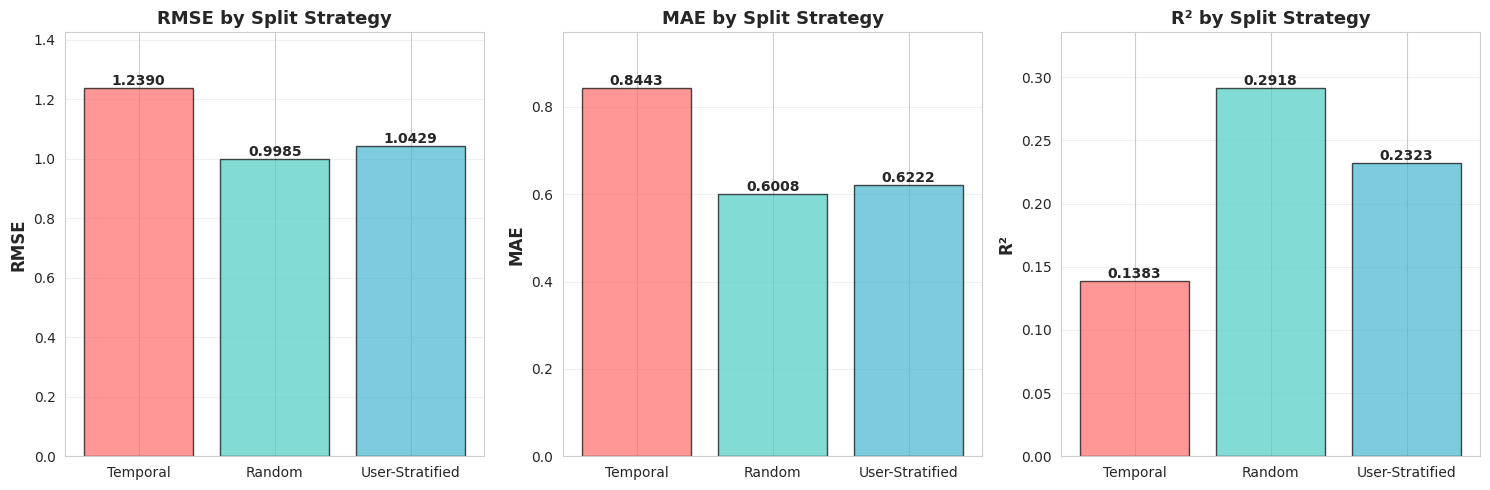


PERFORMANCE IMPROVEMENTS vs. TEMPORAL SPLIT

Random:
  RMSE: +19.40% improvement
  MAE:  +28.84% improvement
  R²:   +110.91% improvement

User-Stratified:
  RMSE: +15.82% improvement
  MAE:  +26.30% improvement
  R²:   +67.88% improvement


In [11]:
results = pd.DataFrame({
    'Split Strategy': ['Temporal', 'Random', 'User-Stratified'],
    'RMSE': [rmse, rmse_random, rmse_strat],
    'MAE': [test_mae, mae_random, mae_strat],
    'R²': [r2, r2_random, r2_strat]
})

print("\n" + "="*60)
print("PERFORMANCE COMPARISON ACROSS SPLIT STRATEGIES")
print("="*60)
print(results.to_string(index=False))
print("="*60)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = results[metric].values
    bars = ax.bar(results['Split Strategy'], values, color=colors, alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} by Split Strategy', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

# Calculate percentage improvements
print("\n" + "="*60)
print("PERFORMANCE IMPROVEMENTS vs. TEMPORAL SPLIT")
print("="*60)
for split_name, rmse_val, mae_val, r2_val in zip(results['Split Strategy'][1:],
                                                   results['RMSE'][1:],
                                                   results['MAE'][1:],
                                                   results['R²'][1:]):
    rmse_improvement = ((rmse - rmse_val) / rmse) * 100
    mae_improvement = ((test_mae - mae_val) / test_mae) * 100
    r2_improvement = ((r2_val - r2) / abs(r2)) * 100

    print(f"\n{split_name}:")
    print(f"  RMSE: {rmse_improvement:+.2f}% improvement")
    print(f"  MAE:  {mae_improvement:+.2f}% improvement")
    print(f"  R²:   {r2_improvement:+.2f}% improvement")
print("="*60)